In [1]:
import cv2
import flow_vis
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage as ndi
from skimage import color, img_as_float32
from skimage.transform import pyramid_reduce, resize,warp

In [2]:
def resize_flow_vectors(u, v, lvl):
    r, c = u.shape
    u = resize(u, lvl.shape, order=0, preserve_range=True,anti_aliasing=False)
    v = resize(v, lvl.shape, order=0, preserve_range=True,anti_aliasing=False)
    scaled_y, scaled_x = lvl.shape[0]/r, lvl.shape[1]/c
    resized_u, resized_v = scaled_x*u, scaled_y*v
    return resized_u, resized_v

In [3]:
def pyramid_(img_base, pyr_lvl, min_size):
    pyramid_struct = [img_base]
    img_size = min(img_base.shape[0],img_base.shape[1])
    for i in range(1,pyr_lvl):
        if img_size > min_size:
            lvl = pyramid_reduce(pyramid_struct[-1], downscale=2.0)
            pyramid_struct.append(lvl)
            img_size = min(lvl.shape[0],lvl.shape[1])
    return pyramid_struct[::-1]

In [4]:
def coarse2fine(frame0, frame1, solver, pyr_lvl=10, min_size=16):

    if frame0.ndim == 3:
        frame0 = color.rgb2gray(frame0)
    if frame1.ndim == 3:
        frame1 = color.rgb2gray(frame1)
    if frame0.shape != frame1.shape:
        print ("Input images should have the same shape")
        exit()

    pyramid_f0 = pyramid_(img_as_float32(frame0),pyr_lvl, min_size)
    pyramid_f1 = pyramid_(img_as_float32(frame1),pyr_lvl, min_size)
    pyramid = list(zip(pyramid_f0, pyramid_f1))

    u, v = np.zeros_like(pyramid[0][0]), np.zeros_like(pyramid[0][0])
    u, v = solver(pyramid[0][0], pyramid[0][1], u, v)
    for lvl_prev, lvl_nex in pyramid[1:]:
        u, v = resize_flow_vectors(u, v, lvl_prev)
        u, v = solver(lvl_prev, lvl_nex, u, v)
    return u, v

In [5]:
def optical_flow_interpolation_error(frame0, frame1, flow):
    flow_c = flow.copy()
    h = flow.shape[0]
    w = flow.shape[1]
    flow_c *= -1
    flow_c[:,:,0] += np.arange(w)
    flow_c[:,:,1] += np.arange(h)[:,np.newaxis]
    interpolated_frame = cv2.remap(frame0.astype(np.float32), flow_c.astype(np.float32), None, cv2.INTER_LINEAR)
    mse = np.square(np.subtract(frame1.astype(np.float32),interpolated_frame)).mean()
    return mse, interpolated_frame

In [6]:
def lucaskanade_main(frame0, frame1, u0, v0, rad, nwarp):    
    r, c = frame0.shape
    y, x = np.mgrid[:r, :c]
    sigma_val = (2*rad+1)/4
    u,v = u0.copy(),v0.copy()
    for i in range(nwarp):
        warp_f1 = warp(frame1, np.array([y+v, x+u]), mode='constant', order=0)
        Iy, Ix = np.gradient(warp_f1)
        It = warp_f1 - frame0 - u*Ix - v*Iy
        Ixx = Ix*Ix
        Ixy = Ix*Iy
        Iyy = Iy*Iy
        Ixt = Ix*It
        Iyt = Iy*It
        Ixx = ndi.gaussian_filter(Ixx, sigma=sigma_val, mode='mirror')
        Ixy = ndi.gaussian_filter(Ixy, sigma=sigma_val, mode='mirror')
        Iyy = ndi.gaussian_filter(Iyy, sigma=sigma_val, mode='mirror')
        Ixt = ndi.gaussian_filter(Ixt, sigma=sigma_val, mode='mirror')
        Iyt = ndi.gaussian_filter(Iyt, sigma=sigma_val, mode='mirror')
        detA = -(Ixx*Iyy - Ixy*Ixy)
        idx = abs(detA) < 1e-14
        detA[idx] = 1
        u = (Ixt*Iyy - Ixy*Iyt)/detA
        v = (Iyt*Ixx - Ixy*Ixt)/detA
        u[idx] = 0
        v[idx] = 0
    return u, v

In [7]:
def compute_lucas_kanade(frame0, frame1, rad=7, nwarp=10):
    solver = partial(lucaskanade_main, rad=rad, nwarp=nwarp)
    return coarse2fine(frame0, frame1, solver)

In [8]:
def visualize_flow_arrows(u, v, frame1):
    n, m = u.shape
    [X,Y] = np.meshgrid(np.arange(m, dtype = 'float32'), np.arange(n, dtype = 'float32'))
    X_deci = X[np.ix_(range(0, n, 5), range(0, m, 5))]
    Y_deci = Y[np.ix_(range(0, n, 5), range(0, m, 5))]
    u_deci = u[np.ix_(range(0, n, 5), range(0, m, 5))]
    v_deci = v[np.ix_(range(0, n, 5), range(0, m, 5))]
    plt.figure(figsize=(15,15))
    plt.imshow(frame1,cmap='gray')
    plt.quiver(X_deci, Y_deci, u_deci, v_deci)
    plt.title('flow vectors')
    plt.show()

In [9]:
def plot_lucas_kanade_result(img_name, radii):
    prev_frame=f"eval-data/{img_name}/frame10.png"
    curr_frame=f"eval-data/{img_name}/frame11.png"
    
    prev_frame=cv2.imread(prev_frame)
    prev_frame_gray=cv2.cvtColor(prev_frame,cv2.COLOR_BGR2GRAY)
    prev_frame_rgb = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2RGB)
    curr_frame=cv2.imread(curr_frame)
    curr_frame_gray=cv2.cvtColor(curr_frame,cv2.COLOR_BGR2GRAY)
    
    mse_r = []
    for r in radii:
        u, v = compute_lucas_kanade(prev_frame_gray, curr_frame_gray, rad=r)
        flow = np.stack((u,v), axis=-1)
        mse, _ = optical_flow_interpolation_error(prev_frame_gray, curr_frame_gray, flow)
        mse_r.append(mse)
        
    with plt.style.context('ggplot'):
        plt.plot(radii, mse_r)
        plt.title(f"DTV-L1 ({img_name})")
        plt.xlabel("Lambda")
        plt.ylabel("MSE")
        plt.show()
    
    best_radius = radii[mse_r.index(min(mse_r))]
    
    u, v = compute_lucas_kanade(prev_frame_gray, curr_frame_gray, rad=best_radius)
    visualize_flow_arrows(u, v, prev_frame_rgb)
    plt.show()
    pl = flow_vis.flow_uv_to_colors(u, v)
    plt.imshow(pl)
    plt.show()
    mse, new_frame = optical_flow_interpolation_error(prev_frame_gray, curr_frame_gray, np.stack((u, v), axis=-1)
                                                      )
    print("Radius: ", best_radius)
    print("Interpolation Error (MSE): ", mse)

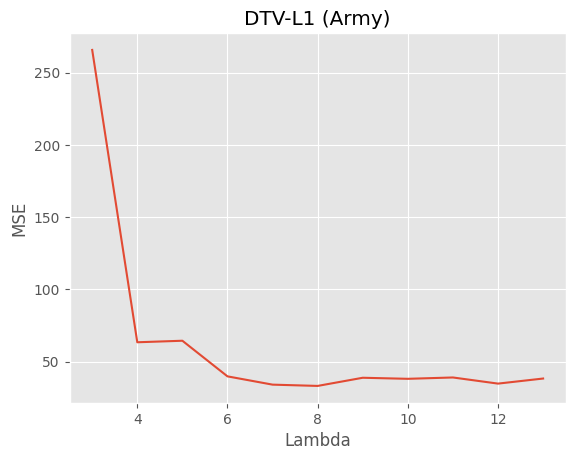

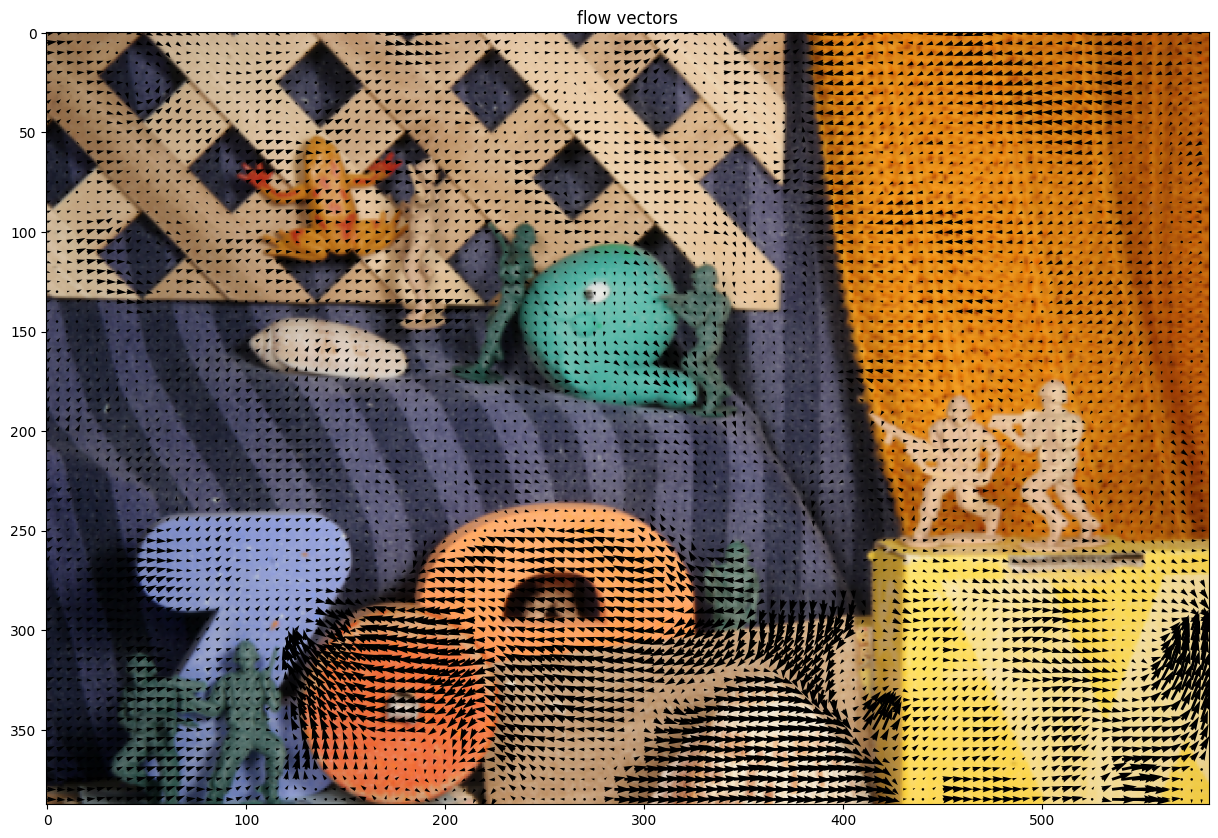

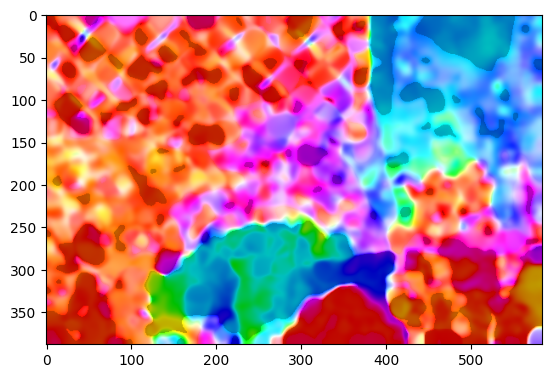

Radius:  8
Interpolation Error (MSE):  33.154125


In [10]:
plot_lucas_kanade_result("Army", np.arange(3,14))

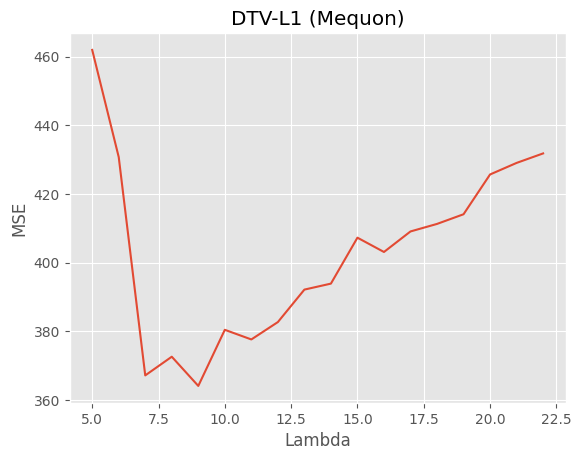

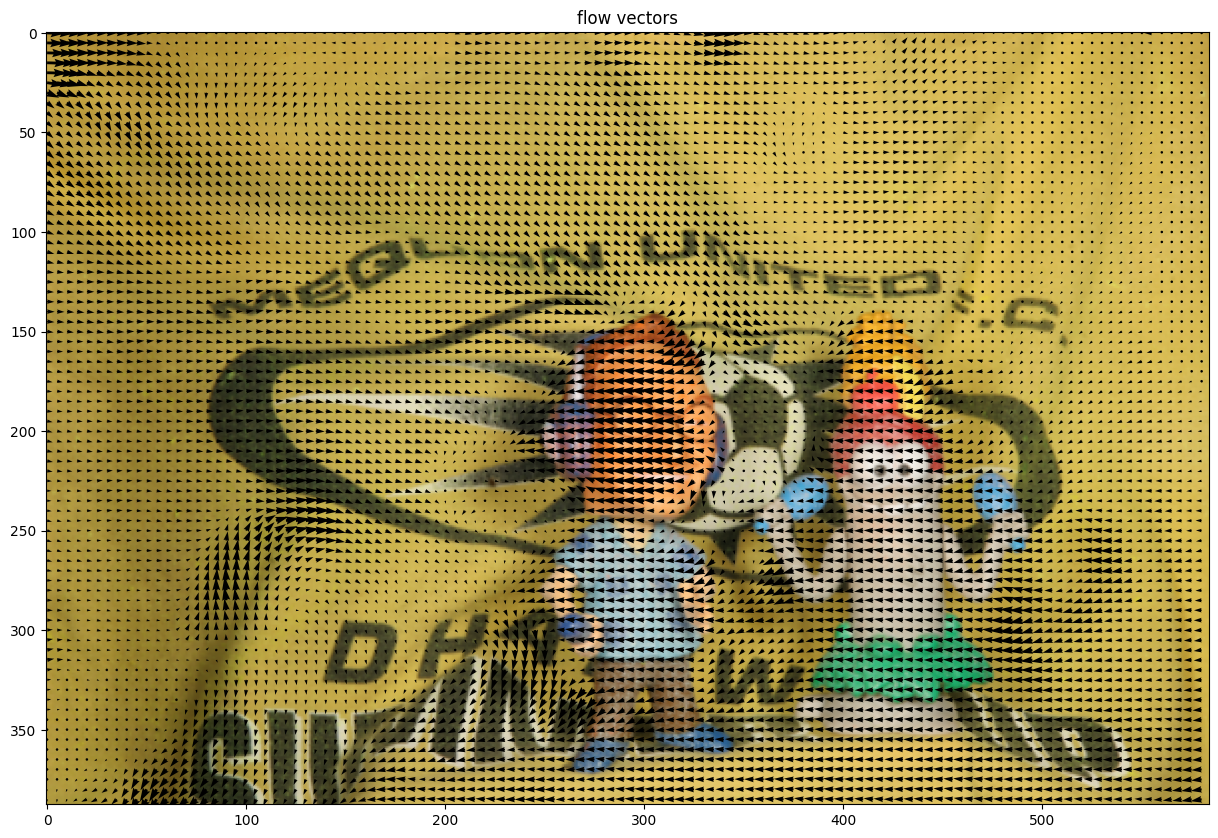

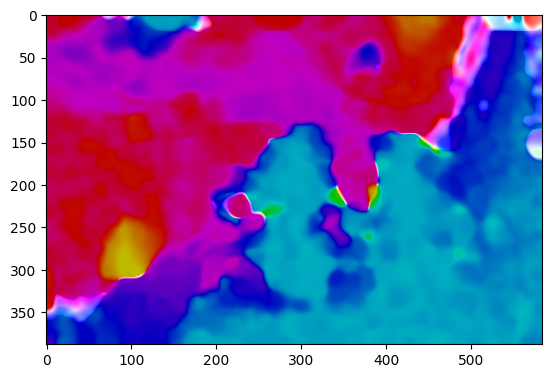

Radius:  9
Interpolation Error (MSE):  364.1431


In [11]:
plot_lucas_kanade_result("Mequon", np.arange(5,23))

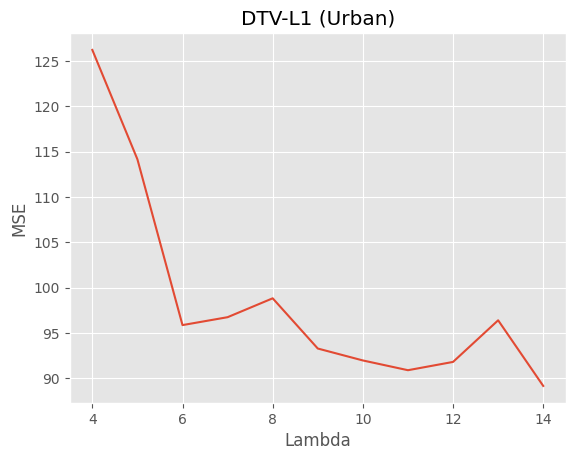

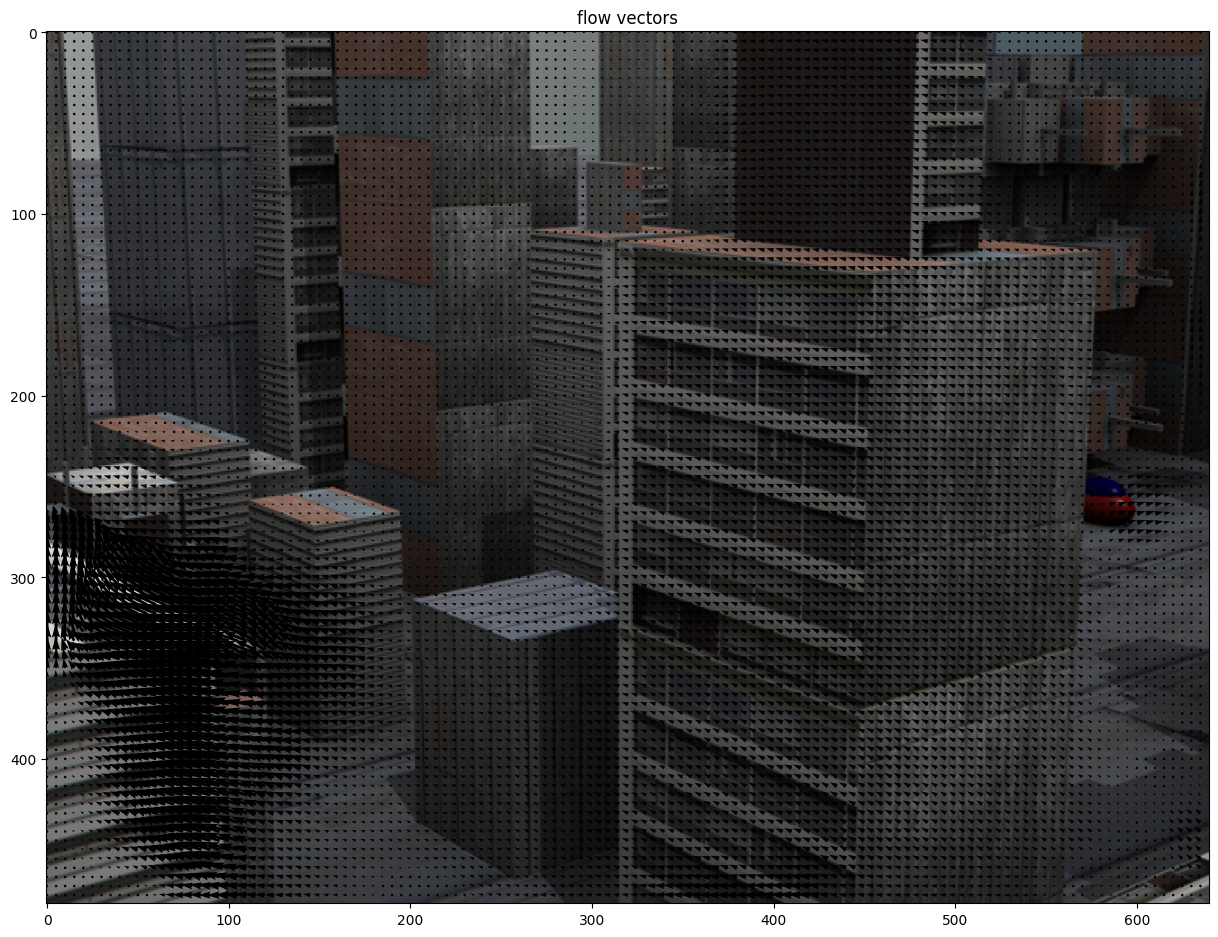

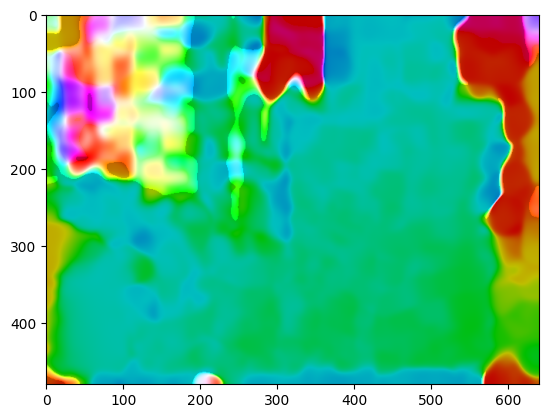

Radius:  14
Interpolation Error (MSE):  89.16502


In [12]:
plot_lucas_kanade_result("Urban", np.arange(4,15))